In [1]:
import torch
import numpy as np
import data
import tqdm
from torchvision.transforms import v2
import models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

/home/anirudh/Documents/GSoC/DeepLense/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [2]:
EPOCHS = 200
BATCH_SIZE = 64
LR = 1e-4
OUT_CLASSES = 3

In [3]:
def transform():
    """
    Data augmentation by random rotation, and random scaling between 0.8 to 1.2

    :return: RandomAffine module that performs the transformation 
    """
    return v2.RandomAffine(degrees=(-180,180),scale=(0.8,1.2))

model = models.Resnet_simple().to(device)

In [4]:
train_dataset = data.LensingDataset('index.csv','../dataset/train/',transform=transform)
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [0.9, 0.1])

train_dataloader = torch.utils.data.DataLoader(train_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)
val_dataloader = torch.utils.data.DataLoader(val_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)

In [5]:
loss_fn = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(params=model.parameters(),lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,'min',patience=2,factor=0.1)
history = {'val_loss':[], 'acc':[], 'loss':[]}
best_val_loss = np.inf
best_weights = None
for epoch in range(EPOCHS):
    losses = []
    accs = []
    model.train()
    for i,(x,y) in enumerate(tqdm.tqdm(train_dataloader, desc=f"Training epoch {epoch+1}")):
        (x, y) = (x.float().to(device), y.to(device))
        x = model(x)
        loss = loss_fn(x,y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        label_indices = torch.argmax(y, 1)
        prediction_indices = torch.argmax(x, 1)
        acc = float(torch.sum(label_indices == prediction_indices))/float(len(label_indices))
        losses.append(float(loss))
        accs.append(float(acc))
    print("Training at epoch %d/%d: %.4f with acc=%.5f at LR=%.6f"%(epoch+1,EPOCHS,np.mean(losses),np.mean(accs),opt.param_groups[0]['lr']))
    history['loss'].append(np.mean(losses))
    train_loss = np.mean(losses)
    model.eval()
    losses = []
    accs = []
    for i,(x,y) in enumerate(tqdm.tqdm(val_dataloader, desc=f"Validation epoch {epoch}")):
        (x, y) = (x.float().to(device), y.to(device))
        x = model(x)
        val_loss = loss_fn(x,y)
        label_indices = torch.argmax(y, 1)
        prediction_indices = torch.argmax(x, 1)
        acc = float(torch.sum(label_indices == prediction_indices))/float(len(label_indices))
        losses.append(float(val_loss))
        accs.append(float(acc))
    if best_val_loss > np.mean(losses):
        best_val_loss = np.mean(losses)
        best_weights = model.state_dict()
    history['val_loss'].append(np.mean(losses))
    history['acc'].append(np.mean(accs))
    print(f"Validation at epoch {epoch+1}/{EPOCHS}: {np.mean(losses)} with acc={np.mean(accs)} at LR={opt.param_groups[0]['lr']}")
    scheduler.step(train_loss)

Training epoch 1: 100%|██████████| 422/422 [00:42<00:00,  9.96it/s]


Training at epoch 1/200: 1.1314 with acc=0.33868 at LR=0.000100


Validation epoch 0: 100%|██████████| 47/47 [00:02<00:00, 20.12it/s]


Validation at epoch 1/200: 1.104361912037464 with acc=0.3464570668693009 at LR=0.0001


Training epoch 2: 100%|██████████| 422/422 [00:39<00:00, 10.78it/s]


Training at epoch 2/200: 1.1039 with acc=0.33836 at LR=0.000100


Validation epoch 1: 100%|██████████| 47/47 [00:02<00:00, 20.63it/s]


Validation at epoch 2/200: 1.0990431917474626 with acc=0.3489741641337386 at LR=0.0001


Training epoch 3: 100%|██████████| 422/422 [00:39<00:00, 10.76it/s]


Training at epoch 3/200: 1.0992 with acc=0.34008 at LR=0.000100


Validation epoch 2: 100%|██████████| 47/47 [00:02<00:00, 20.40it/s]


Validation at epoch 3/200: 1.099063092089714 with acc=0.34997150455927056 at LR=0.0001


Training epoch 4: 100%|██████████| 422/422 [00:39<00:00, 10.71it/s]


Training at epoch 4/200: 1.0954 with acc=0.36062 at LR=0.000100


Validation epoch 3: 100%|██████████| 47/47 [00:02<00:00, 20.34it/s]


Validation at epoch 4/200: 1.098761388596068 with acc=0.3561455167173252 at LR=0.0001


Training epoch 5: 100%|██████████| 422/422 [00:39<00:00, 10.76it/s]


Training at epoch 5/200: 1.0845 with acc=0.38626 at LR=0.000100


Validation epoch 4: 100%|██████████| 47/47 [00:02<00:00, 20.48it/s]


Validation at epoch 5/200: 1.1987223650546783 with acc=0.3417078267477204 at LR=0.0001


Training epoch 6: 100%|██████████| 422/422 [00:39<00:00, 10.72it/s]


Training at epoch 6/200: 1.0559 with acc=0.43541 at LR=0.000100


Validation epoch 5: 100%|██████████| 47/47 [00:02<00:00, 20.58it/s]


Validation at epoch 6/200: 1.1985665534405 with acc=0.3459821428571429 at LR=0.0001


Training epoch 7: 100%|██████████| 422/422 [00:39<00:00, 10.68it/s]


Training at epoch 7/200: 1.0214 with acc=0.48571 at LR=0.000100


Validation epoch 6: 100%|██████████| 47/47 [00:02<00:00, 20.34it/s]


Validation at epoch 7/200: 1.1527902268348855 with acc=0.3805091185410335 at LR=0.0001


Training epoch 8: 100%|██████████| 422/422 [00:39<00:00, 10.72it/s]


Training at epoch 8/200: 1.0002 with acc=0.51753 at LR=0.000100


Validation epoch 7: 100%|██████████| 47/47 [00:02<00:00, 20.60it/s]


Validation at epoch 8/200: 1.1170551041339307 with acc=0.42396466565349544 at LR=0.0001


Training epoch 9: 100%|██████████| 422/422 [00:39<00:00, 10.70it/s]


Training at epoch 9/200: 0.9816 with acc=0.53890 at LR=0.000100


Validation epoch 8: 100%|██████████| 47/47 [00:02<00:00, 20.47it/s]


Validation at epoch 9/200: 1.1516754424318354 with acc=0.39090995440729487 at LR=0.0001


Training epoch 10: 100%|██████████| 422/422 [00:39<00:00, 10.71it/s]


Training at epoch 10/200: 0.9664 with acc=0.55693 at LR=0.000100


Validation epoch 9: 100%|██████████| 47/47 [00:02<00:00, 20.22it/s]


Validation at epoch 10/200: 1.131513591776503 with acc=0.4117591185410335 at LR=0.0001


Training epoch 11: 100%|██████████| 422/422 [00:39<00:00, 10.68it/s]


Training at epoch 11/200: 0.9547 with acc=0.57220 at LR=0.000100


Validation epoch 10: 100%|██████████| 47/47 [00:02<00:00, 19.91it/s]


Validation at epoch 11/200: 1.0935179806770163 with acc=0.44329407294832823 at LR=0.0001


Training epoch 12: 100%|██████████| 422/422 [00:39<00:00, 10.67it/s]


Training at epoch 12/200: 0.9447 with acc=0.58357 at LR=0.000100


Validation epoch 11: 100%|██████████| 47/47 [00:02<00:00, 20.44it/s]


Validation at epoch 12/200: 1.0823934433308053 with acc=0.4529825227963526 at LR=0.0001


Training epoch 13: 100%|██████████| 422/422 [00:39<00:00, 10.70it/s]


Training at epoch 13/200: 0.9385 with acc=0.59064 at LR=0.000100


Validation epoch 12: 100%|██████████| 47/47 [00:02<00:00, 20.17it/s]


Validation at epoch 13/200: 1.0708787086162161 with acc=0.4632883738601824 at LR=0.0001


Training epoch 14: 100%|██████████| 422/422 [00:39<00:00, 10.69it/s]


Training at epoch 14/200: 0.9262 with acc=0.60379 at LR=0.000100


Validation epoch 13: 100%|██████████| 47/47 [00:02<00:00, 20.30it/s]


Validation at epoch 14/200: 1.0284565433542778 with acc=0.5115406534954408 at LR=0.0001


Training epoch 15: 100%|██████████| 422/422 [00:39<00:00, 10.70it/s]


Training at epoch 15/200: 0.9208 with acc=0.61092 at LR=0.000100


Validation epoch 14: 100%|██████████| 47/47 [00:02<00:00, 20.29it/s]


Validation at epoch 15/200: 1.0201663171991389 with acc=0.5177621580547113 at LR=0.0001


Training epoch 16: 100%|██████████| 422/422 [00:39<00:00, 10.67it/s]


Training at epoch 16/200: 0.9116 with acc=0.62043 at LR=0.000100


Validation epoch 15: 100%|██████████| 47/47 [00:02<00:00, 20.37it/s]


Validation at epoch 16/200: 0.9735430770731986 with acc=0.5548537234042553 at LR=0.0001


Training epoch 17: 100%|██████████| 422/422 [00:39<00:00, 10.67it/s]


Training at epoch 17/200: 0.9073 with acc=0.62517 at LR=0.000100


Validation epoch 16: 100%|██████████| 47/47 [00:02<00:00, 19.96it/s]


Validation at epoch 17/200: 1.0436238063142655 with acc=0.49772036474164133 at LR=0.0001


Training epoch 18: 100%|██████████| 422/422 [00:39<00:00, 10.70it/s]


Training at epoch 18/200: 0.9022 with acc=0.63131 at LR=0.000100


Validation epoch 17: 100%|██████████| 47/47 [00:02<00:00, 20.40it/s]


Validation at epoch 18/200: 1.0313126749180732 with acc=0.5081686930091186 at LR=0.0001


Training epoch 19: 100%|██████████| 422/422 [00:39<00:00, 10.71it/s]


Training at epoch 19/200: 0.8931 with acc=0.64077 at LR=0.000100


Validation epoch 18: 100%|██████████| 47/47 [00:02<00:00, 20.40it/s]


Validation at epoch 19/200: 0.974914311094487 with acc=0.5620725683890577 at LR=0.0001


Training epoch 20: 100%|██████████| 422/422 [00:39<00:00, 10.66it/s]


Training at epoch 20/200: 0.8881 with acc=0.64846 at LR=0.000100


Validation epoch 19: 100%|██████████| 47/47 [00:02<00:00, 20.37it/s]


Validation at epoch 20/200: 1.014688400512046 with acc=0.5247910334346505 at LR=0.0001


Training epoch 21: 100%|██████████| 422/422 [00:39<00:00, 10.70it/s]


Training at epoch 21/200: 0.8778 with acc=0.66072 at LR=0.000100


Validation epoch 20: 100%|██████████| 47/47 [00:02<00:00, 20.10it/s]


Validation at epoch 21/200: 1.0120453377987475 with acc=0.5315349544072948 at LR=0.0001


Training epoch 22: 100%|██████████| 422/422 [00:39<00:00, 10.68it/s]


Training at epoch 22/200: 0.8734 with acc=0.66396 at LR=0.000100


Validation epoch 21: 100%|██████████| 47/47 [00:02<00:00, 20.40it/s]


Validation at epoch 22/200: 0.9003650672892307 with acc=0.6387253039513677 at LR=0.0001


Training epoch 23: 100%|██████████| 422/422 [00:39<00:00, 10.67it/s]


Training at epoch 23/200: 0.8645 with acc=0.67444 at LR=0.000100


Validation epoch 22: 100%|██████████| 47/47 [00:02<00:00, 20.43it/s]


Validation at epoch 23/200: 0.9520475522000739 with acc=0.5899506079027356 at LR=0.0001


Training epoch 24: 100%|██████████| 422/422 [00:39<00:00, 10.70it/s]


Training at epoch 24/200: 0.8525 with acc=0.68686 at LR=0.000100


Validation epoch 23: 100%|██████████| 47/47 [00:02<00:00, 20.35it/s]


Validation at epoch 24/200: 0.9164211027165676 with acc=0.6228628419452887 at LR=0.0001


Training epoch 25: 100%|██████████| 422/422 [00:39<00:00, 10.66it/s]


Training at epoch 25/200: 0.8492 with acc=0.69115 at LR=0.000100


Validation epoch 24: 100%|██████████| 47/47 [00:02<00:00, 20.32it/s]


Validation at epoch 25/200: 0.9295440278154739 with acc=0.6089950607902735 at LR=0.0001


Training epoch 26: 100%|██████████| 422/422 [00:39<00:00, 10.68it/s]


Training at epoch 26/200: 0.8383 with acc=0.70145 at LR=0.000100


Validation epoch 25: 100%|██████████| 47/47 [00:02<00:00, 20.40it/s]


Validation at epoch 26/200: 0.9385979226294984 with acc=0.6058130699088146 at LR=0.0001


Training epoch 27: 100%|██████████| 422/422 [00:39<00:00, 10.67it/s]


Training at epoch 27/200: 0.8306 with acc=0.71047 at LR=0.000100


Validation epoch 26: 100%|██████████| 47/47 [00:02<00:00, 20.31it/s]


Validation at epoch 27/200: 0.8736127183792439 with acc=0.6737272036474165 at LR=0.0001


Training epoch 28: 100%|██████████| 422/422 [00:39<00:00, 10.66it/s]


Training at epoch 28/200: 0.8291 with acc=0.71115 at LR=0.000100


Validation epoch 27: 100%|██████████| 47/47 [00:02<00:00, 20.27it/s]


Validation at epoch 28/200: 0.9217869233577809 with acc=0.6184460486322189 at LR=0.0001


Training epoch 29: 100%|██████████| 422/422 [00:39<00:00, 10.67it/s]


Training at epoch 29/200: 0.8165 with acc=0.72553 at LR=0.000100


Validation epoch 28: 100%|██████████| 47/47 [00:02<00:00, 20.40it/s]


Validation at epoch 29/200: 0.9178441217605103 with acc=0.6259973404255319 at LR=0.0001


Training epoch 30: 100%|██████████| 422/422 [00:39<00:00, 10.68it/s]


Training at epoch 30/200: 0.8181 with acc=0.72191 at LR=0.000100


Validation epoch 29: 100%|██████████| 47/47 [00:02<00:00, 19.92it/s]


Validation at epoch 30/200: 0.8862465404449625 with acc=0.6572948328267477 at LR=0.0001


Training epoch 31: 100%|██████████| 422/422 [00:39<00:00, 10.70it/s]


Training at epoch 31/200: 0.8080 with acc=0.73379 at LR=0.000100


Validation epoch 30: 100%|██████████| 47/47 [00:02<00:00, 20.44it/s]


Validation at epoch 31/200: 0.9036472211492822 with acc=0.6402925531914894 at LR=0.0001


Training epoch 32: 100%|██████████| 422/422 [00:39<00:00, 10.64it/s]


Training at epoch 32/200: 0.8017 with acc=0.74020 at LR=0.000100


Validation epoch 31: 100%|██████████| 47/47 [00:02<00:00, 20.26it/s]


Validation at epoch 32/200: 0.87852783913308 with acc=0.6654160334346505 at LR=0.0001


Training epoch 33: 100%|██████████| 422/422 [00:39<00:00, 10.68it/s]


Training at epoch 33/200: 0.8043 with acc=0.73865 at LR=0.000100


Validation epoch 32: 100%|██████████| 47/47 [00:02<00:00, 20.35it/s]


Validation at epoch 33/200: 0.8070214479527575 with acc=0.7382693768996961 at LR=0.0001


Training epoch 34: 100%|██████████| 422/422 [00:39<00:00, 10.71it/s]


Training at epoch 34/200: 0.7947 with acc=0.74712 at LR=0.000100


Validation epoch 33: 100%|██████████| 47/47 [00:02<00:00, 20.25it/s]


Validation at epoch 34/200: 0.8391683583563947 with acc=0.7023176291793313 at LR=0.0001


Training epoch 35: 100%|██████████| 422/422 [00:39<00:00, 10.65it/s]


Training at epoch 35/200: 0.7934 with acc=0.75028 at LR=0.000100


Validation epoch 34: 100%|██████████| 47/47 [00:02<00:00, 20.30it/s]


Validation at epoch 35/200: 0.8209630288976304 with acc=0.7226918693009118 at LR=0.0001


Training epoch 36: 100%|██████████| 422/422 [00:39<00:00, 10.70it/s]


Training at epoch 36/200: 0.7907 with acc=0.75181 at LR=0.000100


Validation epoch 35: 100%|██████████| 47/47 [00:02<00:00, 20.37it/s]


Validation at epoch 36/200: 0.8107463742824311 with acc=0.734375 at LR=0.0001


Training epoch 37: 100%|██████████| 422/422 [00:39<00:00, 10.67it/s]


Training at epoch 37/200: 0.7920 with acc=0.75044 at LR=0.000100


Validation epoch 36: 100%|██████████| 47/47 [00:02<00:00, 20.29it/s]


Validation at epoch 37/200: 0.8199715436773097 with acc=0.7266337386018237 at LR=0.0001


Training epoch 38: 100%|██████████| 422/422 [00:39<00:00, 10.68it/s]


Training at epoch 38/200: 0.7875 with acc=0.75638 at LR=0.000100


Validation epoch 37: 100%|██████████| 47/47 [00:02<00:00, 20.44it/s]


Validation at epoch 38/200: 0.8605702265780023 with acc=0.6827507598784195 at LR=0.0001


Training epoch 39: 100%|██████████| 422/422 [00:39<00:00, 10.69it/s]


Training at epoch 39/200: 0.7843 with acc=0.75796 at LR=0.000100


Validation epoch 38: 100%|██████████| 47/47 [00:02<00:00, 20.48it/s]


Validation at epoch 39/200: 0.8663550196809972 with acc=0.6769566869300911 at LR=0.0001


Training epoch 40: 100%|██████████| 422/422 [00:39<00:00, 10.70it/s]


Training at epoch 40/200: 0.7808 with acc=0.76363 at LR=0.000100


Validation epoch 39: 100%|██████████| 47/47 [00:02<00:00, 20.28it/s]


Validation at epoch 40/200: 0.8081508139346508 with acc=0.7370345744680851 at LR=0.0001


Training epoch 41: 100%|██████████| 422/422 [00:39<00:00, 10.68it/s]


Training at epoch 41/200: 0.7795 with acc=0.76456 at LR=0.000100


Validation epoch 40: 100%|██████████| 47/47 [00:02<00:00, 20.34it/s]


Validation at epoch 41/200: 0.8353060788296639 with acc=0.7111037234042553 at LR=0.0001


Training epoch 42: 100%|██████████| 422/422 [00:39<00:00, 10.70it/s]


Training at epoch 42/200: 0.7775 with acc=0.76619 at LR=0.000100


Validation epoch 41: 100%|██████████| 47/47 [00:02<00:00, 20.23it/s]


Validation at epoch 42/200: 0.8120110948035058 with acc=0.7352773556231004 at LR=0.0001


Training epoch 43: 100%|██████████| 422/422 [00:39<00:00, 10.70it/s]


Training at epoch 43/200: 0.7734 with acc=0.77052 at LR=0.000100


Validation epoch 42: 100%|██████████| 47/47 [00:02<00:00, 20.03it/s]


Validation at epoch 43/200: 0.8436846327274403 with acc=0.7035999240121581 at LR=0.0001


Training epoch 44: 100%|██████████| 422/422 [00:39<00:00, 10.67it/s]


Training at epoch 44/200: 0.7727 with acc=0.76948 at LR=0.000100


Validation epoch 43: 100%|██████████| 47/47 [00:02<00:00, 20.00it/s]


Validation at epoch 44/200: 0.8576735232738738 with acc=0.6888772796352585 at LR=0.0001


Training epoch 45: 100%|██████████| 422/422 [00:39<00:00, 10.65it/s]


Training at epoch 45/200: 0.7712 with acc=0.77373 at LR=0.000100


Validation epoch 44: 100%|██████████| 47/47 [00:02<00:00, 20.18it/s]


Validation at epoch 45/200: 0.8765203851334592 with acc=0.6683605623100304 at LR=0.0001


Training epoch 46: 100%|██████████| 422/422 [00:39<00:00, 10.65it/s]


Training at epoch 46/200: 0.7707 with acc=0.77342 at LR=0.000100


Validation epoch 45: 100%|██████████| 47/47 [00:02<00:00, 20.21it/s]


Validation at epoch 46/200: 0.8779258892891255 with acc=0.6681705927051672 at LR=0.0001


Training epoch 47: 100%|██████████| 422/422 [00:39<00:00, 10.64it/s]


Training at epoch 47/200: 0.7659 with acc=0.77777 at LR=0.000100


Validation epoch 46: 100%|██████████| 47/47 [00:02<00:00, 19.99it/s]


Validation at epoch 47/200: 0.8210681220318409 with acc=0.7239741641337386 at LR=0.0001


Training epoch 48: 100%|██████████| 422/422 [00:39<00:00, 10.61it/s]


Training at epoch 48/200: 0.7627 with acc=0.78290 at LR=0.000100


Validation epoch 47: 100%|██████████| 47/47 [00:02<00:00, 20.08it/s]


Validation at epoch 48/200: 0.8455294941334014 with acc=0.7017477203647415 at LR=0.0001


Training epoch 49: 100%|██████████| 422/422 [00:39<00:00, 10.66it/s]


Training at epoch 49/200: 0.7660 with acc=0.77804 at LR=0.000100


Validation epoch 48: 100%|██████████| 47/47 [00:02<00:00, 19.96it/s]


Validation at epoch 49/200: 0.7972891939447281 with acc=0.7507598784194529 at LR=0.0001


Training epoch 50: 100%|██████████| 422/422 [00:39<00:00, 10.64it/s]


Training at epoch 50/200: 0.7624 with acc=0.78170 at LR=0.000100


Validation epoch 49: 100%|██████████| 47/47 [00:02<00:00, 19.97it/s]


Validation at epoch 50/200: 0.8585385464607401 with acc=0.6889247720364742 at LR=0.0001


Training epoch 51: 100%|██████████| 422/422 [00:39<00:00, 10.65it/s]


Training at epoch 51/200: 0.7578 with acc=0.78756 at LR=0.000100


Validation epoch 50: 100%|██████████| 47/47 [00:02<00:00, 20.26it/s]


Validation at epoch 51/200: 0.7870291129071662 with acc=0.7602583586626139 at LR=0.0001


Training epoch 52: 100%|██████████| 422/422 [00:39<00:00, 10.65it/s]


Training at epoch 52/200: 0.7615 with acc=0.78345 at LR=0.000100


Validation epoch 51: 100%|██████████| 47/47 [00:02<00:00, 20.02it/s]


Validation at epoch 52/200: 0.8578560491825672 with acc=0.6875474924012158 at LR=0.0001


Training epoch 53: 100%|██████████| 422/422 [00:39<00:00, 10.68it/s]


Training at epoch 53/200: 0.7659 with acc=0.77881 at LR=0.000100


Validation epoch 52: 100%|██████████| 47/47 [00:02<00:00, 20.04it/s]


Validation at epoch 53/200: 0.8292090791337033 with acc=0.7174202127659575 at LR=0.0001


Training epoch 54: 100%|██████████| 422/422 [00:39<00:00, 10.65it/s]


Training at epoch 54/200: 0.7560 with acc=0.78831 at LR=0.000100


Validation epoch 53: 100%|██████████| 47/47 [00:02<00:00, 19.95it/s]


Validation at epoch 54/200: 0.8308120712320856 with acc=0.7167078267477203 at LR=0.0001


Training epoch 55: 100%|██████████| 422/422 [00:39<00:00, 10.65it/s]


Training at epoch 55/200: 0.7569 with acc=0.78818 at LR=0.000100


Validation epoch 54: 100%|██████████| 47/47 [00:02<00:00, 20.18it/s]


Validation at epoch 55/200: 0.8093876052410045 with acc=0.736322188449848 at LR=0.0001


Training epoch 56: 100%|██████████| 422/422 [00:39<00:00, 10.62it/s]


Training at epoch 56/200: 0.7573 with acc=0.78791 at LR=0.000100


Validation epoch 55: 100%|██████████| 47/47 [00:02<00:00, 20.05it/s]


Validation at epoch 56/200: 0.7889127325504384 with acc=0.7585961246200608 at LR=0.0001


Training epoch 57: 100%|██████████| 422/422 [00:39<00:00, 10.65it/s]


Training at epoch 57/200: 0.7496 with acc=0.79490 at LR=0.000100


Validation epoch 56: 100%|██████████| 47/47 [00:02<00:00, 19.69it/s]


Validation at epoch 57/200: 0.860182413395415 with acc=0.6898271276595744 at LR=0.0001


Training epoch 58: 100%|██████████| 422/422 [00:39<00:00, 10.65it/s]


Training at epoch 58/200: 0.7476 with acc=0.79778 at LR=0.000100


Validation epoch 57: 100%|██████████| 47/47 [00:02<00:00, 20.10it/s]


Validation at epoch 58/200: 0.774017075274853 with acc=0.7706117021276596 at LR=0.0001


Training epoch 59: 100%|██████████| 422/422 [00:39<00:00, 10.65it/s]


Training at epoch 59/200: 0.7493 with acc=0.79499 at LR=0.000100


Validation epoch 58: 100%|██████████| 47/47 [00:02<00:00, 20.03it/s]


Validation at epoch 59/200: 0.8044554147314518 with acc=0.7444908814589666 at LR=0.0001


Training epoch 60: 100%|██████████| 422/422 [00:39<00:00, 10.65it/s]


Training at epoch 60/200: 0.7521 with acc=0.79204 at LR=0.000100


Validation epoch 59: 100%|██████████| 47/47 [00:02<00:00, 20.03it/s]


Validation at epoch 60/200: 0.8385706835604728 with acc=0.7089190729483283 at LR=0.0001


Training epoch 61: 100%|██████████| 422/422 [00:39<00:00, 10.65it/s]


Training at epoch 61/200: 0.7525 with acc=0.79275 at LR=0.000100


Validation epoch 60: 100%|██████████| 47/47 [00:02<00:00, 19.97it/s]


Validation at epoch 61/200: 0.8466138890449036 with acc=0.700417933130699 at LR=0.0001


Training epoch 62: 100%|██████████| 422/422 [00:39<00:00, 10.67it/s]


Training at epoch 62/200: 0.7310 with acc=0.81493 at LR=0.000010


Validation epoch 61: 100%|██████████| 47/47 [00:02<00:00, 19.82it/s]


Validation at epoch 62/200: 0.7939884903583121 with acc=0.751947188449848 at LR=1e-05


Training epoch 63: 100%|██████████| 422/422 [00:39<00:00, 10.68it/s]


Training at epoch 63/200: 0.7263 with acc=0.82063 at LR=0.000010


Validation epoch 62: 100%|██████████| 47/47 [00:02<00:00, 20.03it/s]


Validation at epoch 63/200: 0.8042577517793533 with acc=0.7433985562310031 at LR=1e-05


Training epoch 64: 100%|██████████| 422/422 [00:39<00:00, 10.68it/s]


Training at epoch 64/200: 0.7230 with acc=0.82290 at LR=0.000010


Validation epoch 63: 100%|██████████| 47/47 [00:02<00:00, 20.15it/s]


Validation at epoch 64/200: 0.7753383060719105 with acc=0.7701367781155015 at LR=1e-05


Training epoch 65: 100%|██████████| 422/422 [00:39<00:00, 10.64it/s]


Training at epoch 65/200: 0.7200 with acc=0.82630 at LR=0.000010


Validation epoch 64: 100%|██████████| 47/47 [00:02<00:00, 19.97it/s]


Validation at epoch 65/200: 0.7739902645983594 with acc=0.7730338145896656 at LR=1e-05


Training epoch 66: 100%|██████████| 422/422 [00:39<00:00, 10.65it/s]


Training at epoch 66/200: 0.7200 with acc=0.82582 at LR=0.000010


Validation epoch 65: 100%|██████████| 47/47 [00:02<00:00, 19.74it/s]


Validation at epoch 66/200: 0.7972522314558638 with acc=0.7500949848024316 at LR=1e-05


Training epoch 67: 100%|██████████| 422/422 [00:39<00:00, 10.64it/s]


Training at epoch 67/200: 0.7256 with acc=0.82092 at LR=0.000010


Validation epoch 66: 100%|██████████| 47/47 [00:02<00:00, 20.06it/s]


Validation at epoch 67/200: 0.7861133813858032 with acc=0.7616356382978723 at LR=1e-05


Training epoch 68: 100%|██████████| 422/422 [00:39<00:00, 10.63it/s]


Training at epoch 68/200: 0.7204 with acc=0.82603 at LR=0.000010


Validation epoch 67: 100%|██████████| 47/47 [00:02<00:00, 19.69it/s]


Validation at epoch 68/200: 0.7745512673195373 with acc=0.7711341185410334 at LR=1e-05


Training epoch 69: 100%|██████████| 422/422 [00:39<00:00, 10.64it/s]


Training at epoch 69/200: 0.7196 with acc=0.82640 at LR=0.000001


Validation epoch 68: 100%|██████████| 47/47 [00:02<00:00, 19.96it/s]


Validation at epoch 69/200: 0.7678746581077576 with acc=0.7787803951367781 at LR=1.0000000000000002e-06


Training epoch 70: 100%|██████████| 422/422 [00:39<00:00, 10.63it/s]


Training at epoch 70/200: 0.7187 with acc=0.82816 at LR=0.000001


Validation epoch 69: 100%|██████████| 47/47 [00:02<00:00, 19.99it/s]


Validation at epoch 70/200: 0.7809596049024704 with acc=0.7644851823708206 at LR=1.0000000000000002e-06


Training epoch 71: 100%|██████████| 422/422 [00:39<00:00, 10.67it/s]


Training at epoch 71/200: 0.7190 with acc=0.82710 at LR=0.000001


Validation epoch 70: 100%|██████████| 47/47 [00:02<00:00, 19.81it/s]


Validation at epoch 71/200: 0.774372528208063 with acc=0.770279255319149 at LR=1.0000000000000002e-06


Training epoch 72: 100%|██████████| 422/422 [00:39<00:00, 10.66it/s]


Training at epoch 72/200: 0.7190 with acc=0.82754 at LR=0.000001


Validation epoch 71: 100%|██████████| 47/47 [00:02<00:00, 20.15it/s]


Validation at epoch 72/200: 0.779427927859286 with acc=0.7671447568389057 at LR=1.0000000000000002e-06


Training epoch 73: 100%|██████████| 422/422 [00:39<00:00, 10.63it/s]


Training at epoch 73/200: 0.7202 with acc=0.82570 at LR=0.000001


Validation epoch 72: 100%|██████████| 47/47 [00:02<00:00, 19.89it/s]


Validation at epoch 73/200: 0.7884121600617754 with acc=0.7577887537993921 at LR=1.0000000000000002e-06


Training epoch 74: 100%|██████████| 422/422 [00:39<00:00, 10.65it/s]


Training at epoch 74/200: 0.7161 with acc=0.83097 at LR=0.000000


Validation epoch 73: 100%|██████████| 47/47 [00:02<00:00, 20.01it/s]


Validation at epoch 74/200: 0.7760912458947364 with acc=0.7703267477203648 at LR=1.0000000000000002e-07


Training epoch 75: 100%|██████████| 422/422 [00:39<00:00, 10.64it/s]


Training at epoch 75/200: 0.7182 with acc=0.82822 at LR=0.000000


Validation epoch 74: 100%|██████████| 47/47 [00:02<00:00, 19.67it/s]


Validation at epoch 75/200: 0.7748161871382531 with acc=0.7724164133738602 at LR=1.0000000000000002e-07


Training epoch 76: 100%|██████████| 422/422 [00:39<00:00, 10.63it/s]


Training at epoch 76/200: 0.7147 with acc=0.83113 at LR=0.000000


Validation epoch 75: 100%|██████████| 47/47 [00:02<00:00, 19.86it/s]


Validation at epoch 76/200: 0.7879664200417539 with acc=0.7595934650455927 at LR=1.0000000000000002e-07


Training epoch 77: 100%|██████████| 422/422 [00:39<00:00, 10.67it/s]


Training at epoch 77/200: 0.7189 with acc=0.82734 at LR=0.000000


Validation epoch 76: 100%|██████████| 47/47 [00:02<00:00, 19.98it/s]


Validation at epoch 77/200: 0.789854350242209 with acc=0.7582161854103344 at LR=1.0000000000000002e-07


Training epoch 78: 100%|██████████| 422/422 [00:39<00:00, 10.67it/s]


Training at epoch 78/200: 0.7186 with acc=0.82738 at LR=0.000000


Validation epoch 77: 100%|██████████| 47/47 [00:02<00:00, 19.71it/s]


Validation at epoch 78/200: 0.7787566134270202 with acc=0.7669072948328267 at LR=1.0000000000000002e-07


Training epoch 79: 100%|██████████| 422/422 [00:39<00:00, 10.63it/s]


Training at epoch 79/200: 0.7200 with acc=0.82719 at LR=0.000000


Validation epoch 78: 100%|██████████| 47/47 [00:02<00:00, 19.74it/s]


Validation at epoch 79/200: 0.7759648789750769 with acc=0.7684745440729482 at LR=1.0000000000000002e-07


Training epoch 80: 100%|██████████| 422/422 [00:39<00:00, 10.64it/s]


Training at epoch 80/200: 0.7154 with acc=0.83132 at LR=0.000000


Validation epoch 79: 100%|██████████| 47/47 [00:02<00:00, 19.94it/s]


Validation at epoch 80/200: 0.7708742047878022 with acc=0.7758358662613982 at LR=1.0000000000000004e-08


Training epoch 81: 100%|██████████| 422/422 [00:39<00:00, 10.66it/s]


Training at epoch 81/200: 0.7156 with acc=0.83064 at LR=0.000000


Validation epoch 80: 100%|██████████| 47/47 [00:02<00:00, 19.92it/s]


Validation at epoch 81/200: 0.7643063436163232 with acc=0.7819623860182372 at LR=1.0000000000000004e-08


Training epoch 82: 100%|██████████| 422/422 [00:39<00:00, 10.63it/s]


Training at epoch 82/200: 0.7157 with acc=0.83108 at LR=0.000000


Validation epoch 81: 100%|██████████| 47/47 [00:02<00:00, 19.93it/s]


Validation at epoch 82/200: 0.7744726881067804 with acc=0.7721789513677811 at LR=1.0000000000000004e-08


Training epoch 83: 100%|██████████| 422/422 [00:39<00:00, 10.64it/s]


Training at epoch 83/200: 0.7164 with acc=0.82957 at LR=0.000000


Validation epoch 82: 100%|██████████| 47/47 [00:02<00:00, 20.01it/s]


Validation at epoch 83/200: 0.7786651824383025 with acc=0.7681895896656535 at LR=1.0000000000000004e-08


Training epoch 84: 100%|██████████| 422/422 [00:39<00:00, 10.64it/s]


Training at epoch 84/200: 0.7176 with acc=0.82786 at LR=0.000000


Validation epoch 83: 100%|██████████| 47/47 [00:02<00:00, 20.15it/s]


Validation at epoch 84/200: 0.7748281841582441 with acc=0.7721314589665653 at LR=1.0000000000000004e-08


Training epoch 85: 100%|██████████| 422/422 [00:39<00:00, 10.66it/s]


Training at epoch 85/200: 0.7175 with acc=0.82938 at LR=0.000000


Validation epoch 84: 100%|██████████| 47/47 [00:02<00:00, 19.91it/s]


Validation at epoch 85/200: 0.774846282411129 with acc=0.7708491641337386 at LR=1.0000000000000004e-08


Training epoch 86: 100%|██████████| 422/422 [00:39<00:00, 10.63it/s]


Training at epoch 86/200: 0.7149 with acc=0.83182 at LR=0.000000


Validation epoch 85: 100%|██████████| 47/47 [00:02<00:00, 20.03it/s]


Validation at epoch 86/200: 0.7762007231407977 with acc=0.769044452887538 at LR=1.0000000000000004e-08


Training epoch 87: 100%|██████████| 422/422 [00:39<00:00, 10.63it/s]


Training at epoch 87/200: 0.7177 with acc=0.82878 at LR=0.000000


Validation epoch 86: 100%|██████████| 47/47 [00:02<00:00, 17.55it/s]


Validation at epoch 87/200: 0.7678559701493446 with acc=0.7778780395136777 at LR=1.0000000000000004e-08


Training epoch 88: 100%|██████████| 422/422 [00:39<00:00, 10.59it/s]


Training at epoch 88/200: 0.7145 with acc=0.83217 at LR=0.000000


Validation epoch 87: 100%|██████████| 47/47 [00:02<00:00, 16.83it/s]


Validation at epoch 88/200: 0.7674314100691613 with acc=0.7786854103343465 at LR=1.0000000000000004e-08


Training epoch 89: 100%|██████████| 422/422 [00:39<00:00, 10.65it/s]


Training at epoch 89/200: 0.7145 with acc=0.83227 at LR=0.000000


Validation epoch 88: 100%|██████████| 47/47 [00:02<00:00, 19.69it/s]


Validation at epoch 89/200: 0.8044743360357082 with acc=0.7423062310030395 at LR=1.0000000000000004e-08


Training epoch 90: 100%|██████████| 422/422 [00:39<00:00, 10.68it/s]


Training at epoch 90/200: 0.7152 with acc=0.83166 at LR=0.000000


Validation epoch 89: 100%|██████████| 47/47 [00:02<00:00, 19.82it/s]


Validation at epoch 90/200: 0.7715743551863 with acc=0.773698708206687 at LR=1.0000000000000004e-08


Training epoch 91: 100%|██████████| 422/422 [00:39<00:00, 10.64it/s]


Training at epoch 91/200: 0.7189 with acc=0.82687 at LR=0.000000


Validation epoch 90: 100%|██████████| 47/47 [00:02<00:00, 19.67it/s]


Validation at epoch 91/200: 0.7899248156141727 with acc=0.7577887537993921 at LR=1.0000000000000004e-08


Training epoch 92: 100%|██████████| 422/422 [00:39<00:00, 10.62it/s]


Training at epoch 92/200: 0.7180 with acc=0.82881 at LR=0.000000


Validation epoch 91: 100%|██████████| 47/47 [00:02<00:00, 20.07it/s]


Validation at epoch 92/200: 0.7690896759641931 with acc=0.7798252279635258 at LR=1.0000000000000004e-08


Training epoch 93: 100%|██████████| 422/422 [00:39<00:00, 10.61it/s]


Training at epoch 93/200: 0.7208 with acc=0.82518 at LR=0.000000


Validation epoch 92: 100%|██████████| 47/47 [00:02<00:00, 19.82it/s]


Validation at epoch 93/200: 0.7815147891957709 with acc=0.7651975683890577 at LR=1.0000000000000004e-08


Training epoch 94: 100%|██████████| 422/422 [00:39<00:00, 10.68it/s]


Training at epoch 94/200: 0.7162 with acc=0.83109 at LR=0.000000


Validation epoch 93: 100%|██████████| 47/47 [00:02<00:00, 20.06it/s]


Validation at epoch 94/200: 0.7839166040116168 with acc=0.7617781155015197 at LR=1.0000000000000004e-08


Training epoch 95: 100%|██████████| 422/422 [00:39<00:00, 10.61it/s]


Training at epoch 95/200: 0.7168 with acc=0.83071 at LR=0.000000


Validation epoch 94: 100%|██████████| 47/47 [00:02<00:00, 19.92it/s]


Validation at epoch 95/200: 0.7756809059609758 with acc=0.770279255319149 at LR=1.0000000000000004e-08


Training epoch 96: 100%|██████████| 422/422 [00:39<00:00, 10.66it/s]


Training at epoch 96/200: 0.7169 with acc=0.83021 at LR=0.000000


Validation epoch 95: 100%|██████████| 47/47 [00:02<00:00, 19.85it/s]


Validation at epoch 96/200: 0.7796491498642779 with acc=0.7676196808510638 at LR=1.0000000000000004e-08


Training epoch 97: 100%|██████████| 422/422 [00:39<00:00, 10.65it/s]


Training at epoch 97/200: 0.7206 with acc=0.82608 at LR=0.000000


Validation epoch 96: 100%|██████████| 47/47 [00:02<00:00, 19.78it/s]


Validation at epoch 97/200: 0.7771140565263465 with acc=0.7690919452887538 at LR=1.0000000000000004e-08


Training epoch 98: 100%|██████████| 422/422 [00:39<00:00, 10.66it/s]


Training at epoch 98/200: 0.7180 with acc=0.82984 at LR=0.000000


Validation epoch 97: 100%|██████████| 47/47 [00:02<00:00, 19.97it/s]


Validation at epoch 98/200: 0.7640509656135072 with acc=0.7817249240121581 at LR=1.0000000000000004e-08


Training epoch 99: 100%|██████████| 422/422 [00:39<00:00, 10.68it/s]


Training at epoch 99/200: 0.7173 with acc=0.82880 at LR=0.000000


Validation epoch 98: 100%|██████████| 47/47 [00:02<00:00, 20.01it/s]


Validation at epoch 99/200: 0.7779087728642403 with acc=0.7685220364741642 at LR=1.0000000000000004e-08


Training epoch 100: 100%|██████████| 422/422 [00:39<00:00, 10.62it/s]


Training at epoch 100/200: 0.7140 with acc=0.83301 at LR=0.000000


Validation epoch 99: 100%|██████████| 47/47 [00:02<00:00, 19.60it/s]


Validation at epoch 100/200: 0.7719887330176982 with acc=0.773936170212766 at LR=1.0000000000000004e-08


Training epoch 101: 100%|██████████| 422/422 [00:39<00:00, 10.66it/s]


Training at epoch 101/200: 0.7146 with acc=0.83316 at LR=0.000000


Validation epoch 100: 100%|██████████| 47/47 [00:02<00:00, 20.02it/s]


Validation at epoch 101/200: 0.7902869290493905 with acc=0.7575037993920972 at LR=1.0000000000000004e-08


Training epoch 102: 100%|██████████| 422/422 [00:39<00:00, 10.63it/s]


Training at epoch 102/200: 0.7204 with acc=0.82653 at LR=0.000000


Validation epoch 101: 100%|██████████| 47/47 [00:02<00:00, 19.99it/s]


Validation at epoch 102/200: 0.790026343883352 with acc=0.757551291793313 at LR=1.0000000000000004e-08


Training epoch 103: 100%|██████████| 422/422 [00:39<00:00, 10.65it/s]


Training at epoch 103/200: 0.7195 with acc=0.82750 at LR=0.000000


Validation epoch 102: 100%|██████████| 47/47 [00:02<00:00, 19.87it/s]


Validation at epoch 103/200: 0.7787724099260696 with acc=0.7680471124620061 at LR=1.0000000000000004e-08


Training epoch 104: 100%|██████████| 422/422 [00:39<00:00, 10.63it/s]


Training at epoch 104/200: 0.7160 with acc=0.83015 at LR=0.000000


Validation epoch 103: 100%|██████████| 47/47 [00:02<00:00, 19.80it/s]


Validation at epoch 104/200: 0.7803304943632572 with acc=0.7668123100303951 at LR=1.0000000000000004e-08


Training epoch 105: 100%|██████████| 422/422 [00:39<00:00, 10.63it/s]


Training at epoch 105/200: 0.7155 with acc=0.83124 at LR=0.000000


Validation epoch 104: 100%|██████████| 47/47 [00:02<00:00, 19.84it/s]


Validation at epoch 105/200: 0.7597589568888887 with acc=0.7876614741641337 at LR=1.0000000000000004e-08


Training epoch 106: 100%|██████████| 422/422 [00:39<00:00, 10.66it/s]


Training at epoch 106/200: 0.7132 with acc=0.83365 at LR=0.000000


Validation epoch 105: 100%|██████████| 47/47 [00:02<00:00, 19.96it/s]


Validation at epoch 106/200: 0.7784594132545146 with acc=0.7674772036474163 at LR=1.0000000000000004e-08


Training epoch 107: 100%|██████████| 422/422 [00:39<00:00, 10.64it/s]


Training at epoch 107/200: 0.7155 with acc=0.83190 at LR=0.000000


Validation epoch 106: 100%|██████████| 47/47 [00:02<00:00, 19.76it/s]


Validation at epoch 107/200: 0.7844618482792631 with acc=0.762205547112462 at LR=1.0000000000000004e-08


Training epoch 108: 100%|██████████| 422/422 [00:39<00:00, 10.64it/s]


Training at epoch 108/200: 0.7161 with acc=0.83198 at LR=0.000000


Validation epoch 107: 100%|██████████| 47/47 [00:02<00:00, 19.95it/s]


Validation at epoch 108/200: 0.782606377246532 with acc=0.7647226443768996 at LR=1.0000000000000004e-08


Training epoch 109: 100%|██████████| 422/422 [00:39<00:00, 10.66it/s]


Training at epoch 109/200: 0.7142 with acc=0.83262 at LR=0.000000


Validation epoch 108: 100%|██████████| 47/47 [00:02<00:00, 19.88it/s]


Validation at epoch 109/200: 0.7788802169738932 with acc=0.7673822188449848 at LR=1.0000000000000004e-08


Training epoch 110: 100%|██████████| 422/422 [00:39<00:00, 10.64it/s]


Training at epoch 110/200: 0.7172 with acc=0.82883 at LR=0.000000


Validation epoch 109: 100%|██████████| 47/47 [00:02<00:00, 19.91it/s]


Validation at epoch 110/200: 0.765177088849088 with acc=0.7813924772036475 at LR=1.0000000000000004e-08


Training epoch 111: 100%|██████████| 422/422 [00:39<00:00, 10.64it/s]


Training at epoch 111/200: 0.7165 with acc=0.83010 at LR=0.000000


Validation epoch 110: 100%|██████████| 47/47 [00:02<00:00, 19.68it/s]


Validation at epoch 111/200: 0.7651639948499963 with acc=0.7840045592705167 at LR=1.0000000000000004e-08


Training epoch 112: 100%|██████████| 422/422 [00:39<00:00, 10.65it/s]


Training at epoch 112/200: 0.7159 with acc=0.83003 at LR=0.000000


Validation epoch 111: 100%|██████████| 47/47 [00:02<00:00, 19.69it/s]


Validation at epoch 112/200: 0.7760184724280175 with acc=0.7708491641337386 at LR=1.0000000000000004e-08


Training epoch 113: 100%|██████████| 422/422 [00:39<00:00, 10.61it/s]


Training at epoch 113/200: 0.7189 with acc=0.82867 at LR=0.000000


Validation epoch 112: 100%|██████████| 47/47 [00:02<00:00, 19.67it/s]


Validation at epoch 113/200: 0.7751164144658028 with acc=0.7699468085106383 at LR=1.0000000000000004e-08


Training epoch 114: 100%|██████████| 422/422 [00:39<00:00, 10.66it/s]


Training at epoch 114/200: 0.7163 with acc=0.82980 at LR=0.000000


Validation epoch 113: 100%|██████████| 47/47 [00:02<00:00, 19.82it/s]


Validation at epoch 114/200: 0.7918573097979769 with acc=0.7573613221884499 at LR=1.0000000000000004e-08


Training epoch 115: 100%|██████████| 422/422 [00:39<00:00, 10.64it/s]


Training at epoch 115/200: 0.7154 with acc=0.83208 at LR=0.000000


Validation epoch 114: 100%|██████████| 47/47 [00:02<00:00, 19.51it/s]


Validation at epoch 115/200: 0.7862458951929783 with acc=0.7606382978723404 at LR=1.0000000000000004e-08


Training epoch 116: 100%|██████████| 422/422 [00:39<00:00, 10.64it/s]


Training at epoch 116/200: 0.7164 with acc=0.83129 at LR=0.000000


Validation epoch 115: 100%|██████████| 47/47 [00:02<00:00, 19.87it/s]


Validation at epoch 116/200: 0.7788007817369826 with acc=0.7665748480243161 at LR=1.0000000000000004e-08


Training epoch 117: 100%|██████████| 422/422 [00:39<00:00, 10.61it/s]


Training at epoch 117/200: 0.7145 with acc=0.83241 at LR=0.000000


Validation epoch 116: 100%|██████████| 47/47 [00:02<00:00, 19.82it/s]


Validation at epoch 117/200: 0.7640409203285866 with acc=0.7825322948328267 at LR=1.0000000000000004e-08


Training epoch 118: 100%|██████████| 422/422 [00:39<00:00, 10.67it/s]


Training at epoch 118/200: 0.7178 with acc=0.82872 at LR=0.000000


Validation epoch 117: 100%|██████████| 47/47 [00:02<00:00, 19.81it/s]


Validation at epoch 118/200: 0.7853834476876767 with acc=0.7604958206686929 at LR=1.0000000000000004e-08


Training epoch 119: 100%|██████████| 422/422 [00:39<00:00, 10.65it/s]


Training at epoch 119/200: 0.7176 with acc=0.82899 at LR=0.000000


Validation epoch 118: 100%|██████████| 47/47 [00:02<00:00, 19.76it/s]


Validation at epoch 119/200: 0.7743629825876114 with acc=0.7691394376899695 at LR=1.0000000000000004e-08


Training epoch 120: 100%|██████████| 422/422 [00:39<00:00, 10.64it/s]


Training at epoch 120/200: 0.7153 with acc=0.83110 at LR=0.000000


Validation epoch 119: 100%|██████████| 47/47 [00:02<00:00, 19.81it/s]


Validation at epoch 120/200: 0.77710393515039 with acc=0.7691394376899695 at LR=1.0000000000000004e-08


Training epoch 121: 100%|██████████| 422/422 [00:39<00:00, 10.64it/s]


Training at epoch 121/200: 0.7181 with acc=0.82889 at LR=0.000000


Validation epoch 120: 100%|██████████| 47/47 [00:02<00:00, 19.91it/s]


Validation at epoch 121/200: 0.7703473846963111 with acc=0.7753609422492401 at LR=1.0000000000000004e-08


Training epoch 122: 100%|██████████| 422/422 [00:39<00:00, 10.62it/s]


Training at epoch 122/200: 0.7162 with acc=0.83060 at LR=0.000000


Validation epoch 121: 100%|██████████| 47/47 [00:02<00:00, 19.78it/s]


Validation at epoch 122/200: 0.7809384807627252 with acc=0.7655775075987842 at LR=1.0000000000000004e-08


Training epoch 123: 100%|██████████| 422/422 [00:39<00:00, 10.65it/s]


Training at epoch 123/200: 0.7174 with acc=0.83117 at LR=0.000000


Validation epoch 122: 100%|██████████| 47/47 [00:02<00:00, 19.73it/s]


Validation at epoch 123/200: 0.7731030684836367 with acc=0.7716565349544073 at LR=1.0000000000000004e-08


Training epoch 124: 100%|██████████| 422/422 [00:39<00:00, 10.66it/s]


Training at epoch 124/200: 0.7170 with acc=0.82981 at LR=0.000000


Validation epoch 123: 100%|██████████| 47/47 [00:02<00:00, 19.47it/s]


Validation at epoch 124/200: 0.7783909008858052 with acc=0.7688069908814589 at LR=1.0000000000000004e-08


Training epoch 125: 100%|██████████| 422/422 [00:39<00:00, 10.67it/s]


Training at epoch 125/200: 0.7146 with acc=0.83197 at LR=0.000000


Validation epoch 124: 100%|██████████| 47/47 [00:02<00:00, 19.36it/s]


Validation at epoch 125/200: 0.777420552487069 with acc=0.7677621580547113 at LR=1.0000000000000004e-08


Training epoch 126: 100%|██████████| 422/422 [00:39<00:00, 10.61it/s]


Training at epoch 126/200: 0.7158 with acc=0.82983 at LR=0.000000


Validation epoch 125: 100%|██████████| 47/47 [00:02<00:00, 20.24it/s]


Validation at epoch 126/200: 0.767052412033081 with acc=0.7787803951367781 at LR=1.0000000000000004e-08


Training epoch 127: 100%|██████████| 422/422 [00:39<00:00, 10.68it/s]


Training at epoch 127/200: 0.7188 with acc=0.82710 at LR=0.000000


Validation epoch 126: 100%|██████████| 47/47 [00:02<00:00, 20.37it/s]


Validation at epoch 127/200: 0.786505345334398 with acc=0.760733282674772 at LR=1.0000000000000004e-08


Training epoch 128: 100%|██████████| 422/422 [00:39<00:00, 10.66it/s]


Training at epoch 128/200: 0.7195 with acc=0.82762 at LR=0.000000


Validation epoch 127: 100%|██████████| 47/47 [00:02<00:00, 20.15it/s]


Validation at epoch 128/200: 0.7780656649711284 with acc=0.7690919452887538 at LR=1.0000000000000004e-08


Training epoch 129: 100%|██████████| 422/422 [00:39<00:00, 10.68it/s]


Training at epoch 129/200: 0.7173 with acc=0.82918 at LR=0.000000


Validation epoch 128: 100%|██████████| 47/47 [00:02<00:00, 20.25it/s]


Validation at epoch 129/200: 0.8139844422644757 with acc=0.7342800151975684 at LR=1.0000000000000004e-08


Training epoch 130: 100%|██████████| 422/422 [00:39<00:00, 10.68it/s]


Training at epoch 130/200: 0.7199 with acc=0.82609 at LR=0.000000


Validation epoch 129: 100%|██████████| 47/47 [00:02<00:00, 20.37it/s]


Validation at epoch 130/200: 0.7819106731008976 with acc=0.7638677811550152 at LR=1.0000000000000004e-08


Training epoch 131: 100%|██████████| 422/422 [00:39<00:00, 10.72it/s]


Training at epoch 131/200: 0.7156 with acc=0.83046 at LR=0.000000


Validation epoch 130: 100%|██████████| 47/47 [00:02<00:00, 20.10it/s]


Validation at epoch 131/200: 0.7640127209906883 with acc=0.7829597264437691 at LR=1.0000000000000004e-08


Training epoch 132: 100%|██████████| 422/422 [00:39<00:00, 10.69it/s]


Training at epoch 132/200: 0.7176 with acc=0.82877 at LR=0.000000


Validation epoch 131: 100%|██████████| 47/47 [00:02<00:00, 20.38it/s]


Validation at epoch 132/200: 0.7862152469919083 with acc=0.760733282674772 at LR=1.0000000000000004e-08


Training epoch 133: 100%|██████████| 422/422 [00:39<00:00, 10.72it/s]


Training at epoch 133/200: 0.7136 with acc=0.83399 at LR=0.000000


Validation epoch 132: 100%|██████████| 47/47 [00:02<00:00, 20.10it/s]


Validation at epoch 133/200: 0.7841874589311316 with acc=0.7632028875379939 at LR=1.0000000000000004e-08


Training epoch 134: 100%|██████████| 422/422 [00:39<00:00, 10.68it/s]


Training at epoch 134/200: 0.7153 with acc=0.83125 at LR=0.000000


Validation epoch 133: 100%|██████████| 47/47 [00:02<00:00, 20.14it/s]


Validation at epoch 134/200: 0.787365529131382 with acc=0.7604008358662614 at LR=1.0000000000000004e-08


Training epoch 135: 100%|██████████| 422/422 [00:39<00:00, 10.70it/s]


Training at epoch 135/200: 0.7154 with acc=0.83135 at LR=0.000000


Validation epoch 134: 100%|██████████| 47/47 [00:02<00:00, 20.17it/s]


Validation at epoch 135/200: 0.7834354055688736 with acc=0.7640102583586627 at LR=1.0000000000000004e-08


Training epoch 136: 100%|██████████| 422/422 [00:39<00:00, 10.68it/s]


Training at epoch 136/200: 0.7200 with acc=0.82702 at LR=0.000000


Validation epoch 135: 100%|██████████| 47/47 [00:02<00:00, 20.23it/s]


Validation at epoch 136/200: 0.7894038088778232 with acc=0.7584061550151976 at LR=1.0000000000000004e-08


Training epoch 137: 100%|██████████| 422/422 [00:39<00:00, 10.71it/s]


Training at epoch 137/200: 0.7148 with acc=0.83189 at LR=0.000000


Validation epoch 136: 100%|██████████| 47/47 [00:02<00:00, 20.32it/s]


Validation at epoch 137/200: 0.7672303915023804 with acc=0.779302811550152 at LR=1.0000000000000004e-08


Training epoch 138: 100%|██████████| 422/422 [00:39<00:00, 10.66it/s]


Training at epoch 138/200: 0.7139 with acc=0.83386 at LR=0.000000


Validation epoch 137: 100%|██████████| 47/47 [00:02<00:00, 20.25it/s]


Validation at epoch 138/200: 0.7816743064433971 with acc=0.7635353343465046 at LR=1.0000000000000004e-08


Training epoch 139: 100%|██████████| 422/422 [00:39<00:00, 10.66it/s]


Training at epoch 139/200: 0.7177 with acc=0.82907 at LR=0.000000


Validation epoch 138: 100%|██████████| 47/47 [00:02<00:00, 20.26it/s]


Validation at epoch 139/200: 0.7732427006072187 with acc=0.7720839665653496 at LR=1.0000000000000004e-08


Training epoch 140: 100%|██████████| 422/422 [00:39<00:00, 10.62it/s]


Training at epoch 140/200: 0.7169 with acc=0.83065 at LR=0.000000


Validation epoch 139: 100%|██████████| 47/47 [00:02<00:00, 20.37it/s]


Validation at epoch 140/200: 0.7549031541702595 with acc=0.7896086626139819 at LR=1.0000000000000004e-08


Training epoch 141: 100%|██████████| 422/422 [00:39<00:00, 10.67it/s]


Training at epoch 141/200: 0.7169 with acc=0.82953 at LR=0.000000


Validation epoch 140: 100%|██████████| 47/47 [00:02<00:00, 20.35it/s]


Validation at epoch 141/200: 0.7703432491485108 with acc=0.7753134498480244 at LR=1.0000000000000004e-08


Training epoch 142: 100%|██████████| 422/422 [00:39<00:00, 10.70it/s]


Training at epoch 142/200: 0.7144 with acc=0.83211 at LR=0.000000


Validation epoch 141: 100%|██████████| 47/47 [00:02<00:00, 20.32it/s]


Validation at epoch 142/200: 0.7624650800481756 with acc=0.783434650455927 at LR=1.0000000000000004e-08


Training epoch 143: 100%|██████████| 422/422 [00:39<00:00, 10.68it/s]


Training at epoch 143/200: 0.7167 with acc=0.83061 at LR=0.000000


Validation epoch 142: 100%|██████████| 47/47 [00:02<00:00, 20.31it/s]


Validation at epoch 143/200: 0.7902425616345508 with acc=0.7574088145896656 at LR=1.0000000000000004e-08


Training epoch 144: 100%|██████████| 422/422 [00:39<00:00, 10.69it/s]


Training at epoch 144/200: 0.7175 with acc=0.82902 at LR=0.000000


Validation epoch 143: 100%|██████████| 47/47 [00:02<00:00, 20.16it/s]


Validation at epoch 144/200: 0.7720130973673881 with acc=0.7749335106382979 at LR=1.0000000000000004e-08


Training epoch 145: 100%|██████████| 422/422 [00:39<00:00, 10.68it/s]


Training at epoch 145/200: 0.7185 with acc=0.82766 at LR=0.000000


Validation epoch 144: 100%|██████████| 47/47 [00:02<00:00, 20.25it/s]


Validation at epoch 145/200: 0.7734102479954983 with acc=0.7719414893617021 at LR=1.0000000000000004e-08


Training epoch 146: 100%|██████████| 422/422 [00:39<00:00, 10.69it/s]


Training at epoch 146/200: 0.7175 with acc=0.82963 at LR=0.000000


Validation epoch 145: 100%|██████████| 47/47 [00:02<00:00, 20.15it/s]


Validation at epoch 146/200: 0.7730201774455131 with acc=0.7725588905775075 at LR=1.0000000000000004e-08


Training epoch 147: 100%|██████████| 422/422 [00:39<00:00, 10.67it/s]


Training at epoch 147/200: 0.7182 with acc=0.82917 at LR=0.000000


Validation epoch 146: 100%|██████████| 47/47 [00:02<00:00, 20.44it/s]


Validation at epoch 147/200: 0.7803024624256377 with acc=0.7654825227963525 at LR=1.0000000000000004e-08


Training epoch 148: 100%|██████████| 422/422 [00:39<00:00, 10.69it/s]


Training at epoch 148/200: 0.7138 with acc=0.83344 at LR=0.000000


Validation epoch 147: 100%|██████████| 47/47 [00:02<00:00, 20.22it/s]


Validation at epoch 148/200: 0.7852235639348943 with acc=0.7598309270516717 at LR=1.0000000000000004e-08


Training epoch 149: 100%|██████████| 422/422 [00:39<00:00, 10.70it/s]


Training at epoch 149/200: 0.7163 with acc=0.83104 at LR=0.000000


Validation epoch 148: 100%|██████████| 47/47 [00:02<00:00, 20.13it/s]


Validation at epoch 149/200: 0.7760887260132647 with acc=0.7692344224924011 at LR=1.0000000000000004e-08


Training epoch 150: 100%|██████████| 422/422 [00:39<00:00, 10.67it/s]


Training at epoch 150/200: 0.7142 with acc=0.83372 at LR=0.000000


Validation epoch 149: 100%|██████████| 47/47 [00:02<00:00, 20.11it/s]


Validation at epoch 150/200: 0.7800080471850456 with acc=0.7672397416413373 at LR=1.0000000000000004e-08


Training epoch 151: 100%|██████████| 422/422 [00:39<00:00, 10.70it/s]


Training at epoch 151/200: 0.7175 with acc=0.83009 at LR=0.000000


Validation epoch 150: 100%|██████████| 47/47 [00:02<00:00, 20.14it/s]


Validation at epoch 151/200: 0.7708058306511413 with acc=0.7746010638297872 at LR=1.0000000000000004e-08


Training epoch 152: 100%|██████████| 422/422 [00:39<00:00, 10.70it/s]


Training at epoch 152/200: 0.7152 with acc=0.83113 at LR=0.000000


Validation epoch 151: 100%|██████████| 47/47 [00:02<00:00, 20.13it/s]


Validation at epoch 152/200: 0.7807181122455191 with acc=0.7651500759878419 at LR=1.0000000000000004e-08


Training epoch 153: 100%|██████████| 422/422 [00:39<00:00, 10.67it/s]


Training at epoch 153/200: 0.7155 with acc=0.83074 at LR=0.000000


Validation epoch 152: 100%|██████████| 47/47 [00:02<00:00, 20.10it/s]


Validation at epoch 153/200: 0.7827117798176217 with acc=0.7644851823708206 at LR=1.0000000000000004e-08


Training epoch 154: 100%|██████████| 422/422 [00:39<00:00, 10.67it/s]


Training at epoch 154/200: 0.7175 with acc=0.82857 at LR=0.000000


Validation epoch 153: 100%|██████████| 47/47 [00:02<00:00, 20.32it/s]


Validation at epoch 154/200: 0.782121128224312 with acc=0.7652925531914894 at LR=1.0000000000000004e-08


Training epoch 155: 100%|██████████| 422/422 [00:39<00:00, 10.69it/s]


Training at epoch 155/200: 0.7170 with acc=0.82919 at LR=0.000000


Validation epoch 154: 100%|██████████| 47/47 [00:02<00:00, 20.48it/s]


Validation at epoch 155/200: 0.7566964512175702 with acc=0.7887063069908815 at LR=1.0000000000000004e-08


Training epoch 156: 100%|██████████| 422/422 [00:39<00:00, 10.69it/s]


Training at epoch 156/200: 0.7175 with acc=0.82952 at LR=0.000000


Validation epoch 155: 100%|██████████| 47/47 [00:02<00:00, 20.21it/s]


Validation at epoch 156/200: 0.7671488739074545 with acc=0.7786854103343465 at LR=1.0000000000000004e-08


Training epoch 157: 100%|██████████| 422/422 [00:39<00:00, 10.66it/s]


Training at epoch 157/200: 0.7150 with acc=0.83186 at LR=0.000000


Validation epoch 156: 100%|██████████| 47/47 [00:02<00:00, 20.03it/s]


Validation at epoch 157/200: 0.7704881302853848 with acc=0.7745060790273557 at LR=1.0000000000000004e-08


Training epoch 158: 100%|██████████| 422/422 [00:39<00:00, 10.70it/s]


Training at epoch 158/200: 0.7173 with acc=0.82948 at LR=0.000000


Validation epoch 157: 100%|██████████| 47/47 [00:02<00:00, 20.29it/s]


Validation at epoch 158/200: 0.7855082763002273 with acc=0.7624430091185411 at LR=1.0000000000000004e-08


Training epoch 159: 100%|██████████| 422/422 [00:39<00:00, 10.69it/s]


Training at epoch 159/200: 0.7173 with acc=0.82905 at LR=0.000000


Validation epoch 158: 100%|██████████| 47/47 [00:02<00:00, 20.31it/s]


Validation at epoch 159/200: 0.7689489887115804 with acc=0.775408434650456 at LR=1.0000000000000004e-08


Training epoch 160: 100%|██████████| 422/422 [00:39<00:00, 10.67it/s]


Training at epoch 160/200: 0.7204 with acc=0.82461 at LR=0.000000


Validation epoch 159: 100%|██████████| 47/47 [00:02<00:00, 20.15it/s]


Validation at epoch 160/200: 0.7861748908428435 with acc=0.7612556990881458 at LR=1.0000000000000004e-08


Training epoch 161: 100%|██████████| 422/422 [00:39<00:00, 10.68it/s]


Training at epoch 161/200: 0.7166 with acc=0.82994 at LR=0.000000


Validation epoch 160: 100%|██████████| 47/47 [00:02<00:00, 20.21it/s]


Validation at epoch 161/200: 0.7930846899113757 with acc=0.7562215045592705 at LR=1.0000000000000004e-08


Training epoch 162: 100%|██████████| 422/422 [00:39<00:00, 10.68it/s]


Training at epoch 162/200: 0.7173 with acc=0.82873 at LR=0.000000


Validation epoch 161: 100%|██████████| 47/47 [00:02<00:00, 20.13it/s]


Validation at epoch 162/200: 0.772317573111108 with acc=0.7733662613981763 at LR=1.0000000000000004e-08


Training epoch 163: 100%|██████████| 422/422 [00:39<00:00, 10.67it/s]


Training at epoch 163/200: 0.7188 with acc=0.82810 at LR=0.000000


Validation epoch 162: 100%|██████████| 47/47 [00:02<00:00, 20.11it/s]


Validation at epoch 163/200: 0.7656075231572415 with acc=0.7789703647416414 at LR=1.0000000000000004e-08


Training epoch 164: 100%|██████████| 422/422 [00:39<00:00, 10.65it/s]


Training at epoch 164/200: 0.7189 with acc=0.82805 at LR=0.000000


Validation epoch 163: 100%|██████████| 47/47 [00:02<00:00, 20.34it/s]


Validation at epoch 164/200: 0.7849298981910057 with acc=0.7611132218844985 at LR=1.0000000000000004e-08


Training epoch 165: 100%|██████████| 422/422 [00:39<00:00, 10.65it/s]


Training at epoch 165/200: 0.7184 with acc=0.82839 at LR=0.000000


Validation epoch 164: 100%|██████████| 47/47 [00:02<00:00, 20.12it/s]


Validation at epoch 165/200: 0.7716854062486203 with acc=0.7755034194528876 at LR=1.0000000000000004e-08


Training epoch 166: 100%|██████████| 422/422 [00:39<00:00, 10.70it/s]


Training at epoch 166/200: 0.7175 with acc=0.82846 at LR=0.000000


Validation epoch 165: 100%|██████████| 47/47 [00:02<00:00, 20.26it/s]


Validation at epoch 166/200: 0.7823289759615635 with acc=0.7637727963525837 at LR=1.0000000000000004e-08


Training epoch 167: 100%|██████████| 422/422 [00:39<00:00, 10.70it/s]


Training at epoch 167/200: 0.7177 with acc=0.82833 at LR=0.000000


Validation epoch 166: 100%|██████████| 47/47 [00:02<00:00, 20.29it/s]


Validation at epoch 167/200: 0.7755003051554903 with acc=0.7700892857142858 at LR=1.0000000000000004e-08


Training epoch 168: 100%|██████████| 422/422 [00:39<00:00, 10.68it/s]


Training at epoch 168/200: 0.7160 with acc=0.83061 at LR=0.000000


Validation epoch 167: 100%|██████████| 47/47 [00:02<00:00, 20.27it/s]


Validation at epoch 168/200: 0.7804186978238694 with acc=0.7649601063829787 at LR=1.0000000000000004e-08


Training epoch 169: 100%|██████████| 422/422 [00:39<00:00, 10.68it/s]


Training at epoch 169/200: 0.7164 with acc=0.83061 at LR=0.000000


Validation epoch 168: 100%|██████████| 47/47 [00:02<00:00, 20.14it/s]


Validation at epoch 169/200: 0.8014076859393018 with acc=0.7457731762917933 at LR=1.0000000000000004e-08


Training epoch 170: 100%|██████████| 422/422 [00:39<00:00, 10.69it/s]


Training at epoch 170/200: 0.7163 with acc=0.83044 at LR=0.000000


Validation epoch 169: 100%|██████████| 47/47 [00:02<00:00, 20.38it/s]


Validation at epoch 170/200: 0.7913507869903077 with acc=0.7559840425531915 at LR=1.0000000000000004e-08


Training epoch 171: 100%|██████████| 422/422 [00:39<00:00, 10.67it/s]


Training at epoch 171/200: 0.7165 with acc=0.82925 at LR=0.000000


Validation epoch 170: 100%|██████████| 47/47 [00:02<00:00, 20.22it/s]


Validation at epoch 171/200: 0.7660537146507426 with acc=0.7802526595744681 at LR=1.0000000000000004e-08


Training epoch 172: 100%|██████████| 422/422 [00:39<00:00, 10.67it/s]


Training at epoch 172/200: 0.7171 with acc=0.82872 at LR=0.000000


Validation epoch 171: 100%|██████████| 47/47 [00:02<00:00, 20.24it/s]


Validation at epoch 172/200: 0.768271618701042 with acc=0.7765482522796352 at LR=1.0000000000000004e-08


Training epoch 173: 100%|██████████| 422/422 [00:39<00:00, 10.67it/s]


Training at epoch 173/200: 0.7178 with acc=0.82769 at LR=0.000000


Validation epoch 172: 100%|██████████| 47/47 [00:02<00:00, 19.97it/s]


Validation at epoch 173/200: 0.7805176478751162 with acc=0.7665273556231004 at LR=1.0000000000000004e-08


Training epoch 174: 100%|██████████| 422/422 [00:39<00:00, 10.65it/s]


Training at epoch 174/200: 0.7169 with acc=0.83028 at LR=0.000000


Validation epoch 173: 100%|██████████| 47/47 [00:02<00:00, 20.18it/s]


Validation at epoch 174/200: 0.7764467761871663 with acc=0.7695193768996961 at LR=1.0000000000000004e-08


Training epoch 175: 100%|██████████| 422/422 [00:39<00:00, 10.67it/s]


Training at epoch 175/200: 0.7183 with acc=0.82766 at LR=0.000000


Validation epoch 174: 100%|██████████| 47/47 [00:02<00:00, 20.32it/s]


Validation at epoch 175/200: 0.778429074490324 with acc=0.7696618541033435 at LR=1.0000000000000004e-08


Training epoch 176: 100%|██████████| 422/422 [00:39<00:00, 10.67it/s]


Training at epoch 176/200: 0.7176 with acc=0.82885 at LR=0.000000


Validation epoch 175: 100%|██████████| 47/47 [00:02<00:00, 20.02it/s]


Validation at epoch 176/200: 0.7816325121737541 with acc=0.7647701367781156 at LR=1.0000000000000004e-08


Training epoch 177: 100%|██████████| 422/422 [00:39<00:00, 10.67it/s]


Training at epoch 177/200: 0.7161 with acc=0.83229 at LR=0.000000


Validation epoch 176: 100%|██████████| 47/47 [00:02<00:00, 20.05it/s]


Validation at epoch 177/200: 0.7823135332858309 with acc=0.764390197568389 at LR=1.0000000000000004e-08


Training epoch 178: 100%|██████████| 422/422 [00:39<00:00, 10.69it/s]


Training at epoch 178/200: 0.7139 with acc=0.83258 at LR=0.000000


Validation epoch 177: 100%|██████████| 47/47 [00:02<00:00, 20.20it/s]


Validation at epoch 178/200: 0.7940176801478609 with acc=0.7533719604863223 at LR=1.0000000000000004e-08


Training epoch 179: 100%|██████████| 422/422 [00:39<00:00, 10.68it/s]


Training at epoch 179/200: 0.7186 with acc=0.82819 at LR=0.000000


Validation epoch 178: 100%|██████████| 47/47 [00:02<00:00, 20.07it/s]


Validation at epoch 179/200: 0.7828446157435154 with acc=0.76415273556231 at LR=1.0000000000000004e-08


Training epoch 180: 100%|██████████| 422/422 [00:39<00:00, 10.69it/s]


Training at epoch 180/200: 0.7161 with acc=0.83095 at LR=0.000000


Validation epoch 179: 100%|██████████| 47/47 [00:02<00:00, 20.06it/s]


Validation at epoch 180/200: 0.7833012494635074 with acc=0.7634878419452887 at LR=1.0000000000000004e-08


Training epoch 181: 100%|██████████| 422/422 [00:39<00:00, 10.68it/s]


Training at epoch 181/200: 0.7159 with acc=0.83052 at LR=0.000000


Validation epoch 180: 100%|██████████| 47/47 [00:02<00:00, 20.23it/s]


Validation at epoch 181/200: 0.7810568264190186 with acc=0.766859802431611 at LR=1.0000000000000004e-08


Training epoch 182: 100%|██████████| 422/422 [00:39<00:00, 10.68it/s]


Training at epoch 182/200: 0.7189 with acc=0.82814 at LR=0.000000


Validation epoch 181: 100%|██████████| 47/47 [00:02<00:00, 20.13it/s]


Validation at epoch 182/200: 0.8142643355308695 with acc=0.7333776595744681 at LR=1.0000000000000004e-08


Training epoch 183: 100%|██████████| 422/422 [00:39<00:00, 10.67it/s]


Training at epoch 183/200: 0.7162 with acc=0.83044 at LR=0.000000


Validation epoch 182: 100%|██████████| 47/47 [00:02<00:00, 20.07it/s]


Validation at epoch 183/200: 0.7653380708491548 with acc=0.7819148936170213 at LR=1.0000000000000004e-08


Training epoch 184: 100%|██████████| 422/422 [00:39<00:00, 10.70it/s]


Training at epoch 184/200: 0.7154 with acc=0.83130 at LR=0.000000


Validation epoch 183: 100%|██████████| 47/47 [00:02<00:00, 20.18it/s]


Validation at epoch 184/200: 0.7602650548549409 with acc=0.7859992401215805 at LR=1.0000000000000004e-08


Training epoch 185: 100%|██████████| 422/422 [00:39<00:00, 10.69it/s]


Training at epoch 185/200: 0.7172 with acc=0.82877 at LR=0.000000


Validation epoch 184: 100%|██████████| 47/47 [00:02<00:00, 19.87it/s]


Validation at epoch 185/200: 0.7956177478140973 with acc=0.7509973404255319 at LR=1.0000000000000004e-08


Training epoch 186: 100%|██████████| 422/422 [00:39<00:00, 10.69it/s]


Training at epoch 186/200: 0.7194 with acc=0.82680 at LR=0.000000


Validation epoch 185: 100%|██████████| 47/47 [00:02<00:00, 20.15it/s]


Validation at epoch 186/200: 0.7821835457010472 with acc=0.7642477203647415 at LR=1.0000000000000004e-08


Training epoch 187: 100%|██████████| 422/422 [00:39<00:00, 10.68it/s]


Training at epoch 187/200: 0.7164 with acc=0.83096 at LR=0.000000


Validation epoch 186: 100%|██████████| 47/47 [00:02<00:00, 20.09it/s]


Validation at epoch 187/200: 0.7716196864209277 with acc=0.7747910334346504 at LR=1.0000000000000004e-08


Training epoch 188: 100%|██████████| 422/422 [00:39<00:00, 10.68it/s]


Training at epoch 188/200: 0.7177 with acc=0.82927 at LR=0.000000


Validation epoch 187: 100%|██████████| 47/47 [00:02<00:00, 20.20it/s]


Validation at epoch 188/200: 0.7886814665287099 with acc=0.759498480243161 at LR=1.0000000000000004e-08


Training epoch 189: 100%|██████████| 422/422 [00:39<00:00, 10.69it/s]


Training at epoch 189/200: 0.7165 with acc=0.82944 at LR=0.000000


Validation epoch 188: 100%|██████████| 47/47 [00:02<00:00, 20.02it/s]


Validation at epoch 189/200: 0.7733648977381118 with acc=0.7713715805471124 at LR=1.0000000000000004e-08


Training epoch 190: 100%|██████████| 422/422 [00:39<00:00, 10.69it/s]


Training at epoch 190/200: 0.7189 with acc=0.82837 at LR=0.000000


Validation epoch 189: 100%|██████████| 47/47 [00:02<00:00, 20.15it/s]


Validation at epoch 190/200: 0.7860441740522993 with acc=0.7624905015197568 at LR=1.0000000000000004e-08


Training epoch 191: 100%|██████████| 422/422 [00:39<00:00, 10.69it/s]


Training at epoch 191/200: 0.7159 with acc=0.82975 at LR=0.000000


Validation epoch 190: 100%|██████████| 47/47 [00:02<00:00, 20.07it/s]


Validation at epoch 191/200: 0.7719367882038685 with acc=0.7734612462006079 at LR=1.0000000000000004e-08


Training epoch 192: 100%|██████████| 422/422 [00:39<00:00, 10.71it/s]


Training at epoch 192/200: 0.7143 with acc=0.83290 at LR=0.000000


Validation epoch 191: 100%|██████████| 47/47 [00:02<00:00, 20.46it/s]


Validation at epoch 192/200: 0.8024086343481186 with acc=0.7456781914893617 at LR=1.0000000000000004e-08


Training epoch 193: 100%|██████████| 422/422 [00:39<00:00, 10.71it/s]


Training at epoch 193/200: 0.7148 with acc=0.83110 at LR=0.000000


Validation epoch 192: 100%|██████████| 47/47 [00:02<00:00, 20.26it/s]


Validation at epoch 193/200: 0.7948883328031986 with acc=0.7506648936170213 at LR=1.0000000000000004e-08


Training epoch 194: 100%|██████████| 422/422 [00:39<00:00, 10.67it/s]


Training at epoch 194/200: 0.7159 with acc=0.83031 at LR=0.000000


Validation epoch 193: 100%|██████████| 47/47 [00:02<00:00, 20.28it/s]


Validation at epoch 194/200: 0.7867368700656485 with acc=0.762205547112462 at LR=1.0000000000000004e-08


Training epoch 195: 100%|██████████| 422/422 [00:39<00:00, 10.70it/s]


Training at epoch 195/200: 0.7147 with acc=0.83212 at LR=0.000000


Validation epoch 194: 100%|██████████| 47/47 [00:02<00:00, 20.16it/s]


Validation at epoch 195/200: 0.7783245850116649 with acc=0.7662898936170213 at LR=1.0000000000000004e-08


Training epoch 196: 100%|██████████| 422/422 [00:39<00:00, 10.70it/s]


Training at epoch 196/200: 0.7149 with acc=0.83221 at LR=0.000000


Validation epoch 195: 100%|██████████| 47/47 [00:02<00:00, 20.26it/s]


Validation at epoch 196/200: 0.7587871614922869 with acc=0.7863316869300911 at LR=1.0000000000000004e-08


Training epoch 197: 100%|██████████| 422/422 [00:39<00:00, 10.69it/s]


Training at epoch 197/200: 0.7180 with acc=0.82929 at LR=0.000000


Validation epoch 196: 100%|██████████| 47/47 [00:02<00:00, 19.87it/s]


Validation at epoch 197/200: 0.7678679595602319 with acc=0.777593085106383 at LR=1.0000000000000004e-08


Training epoch 198: 100%|██████████| 422/422 [00:39<00:00, 10.68it/s]


Training at epoch 198/200: 0.7146 with acc=0.83129 at LR=0.000000


Validation epoch 197: 100%|██████████| 47/47 [00:02<00:00, 20.21it/s]


Validation at epoch 198/200: 0.7747518940174833 with acc=0.7717990121580547 at LR=1.0000000000000004e-08


Training epoch 199: 100%|██████████| 422/422 [00:39<00:00, 10.68it/s]


Training at epoch 199/200: 0.7193 with acc=0.82692 at LR=0.000000


Validation epoch 198: 100%|██████████| 47/47 [00:02<00:00, 20.16it/s]


Validation at epoch 199/200: 0.782251719464647 with acc=0.7624905015197568 at LR=1.0000000000000004e-08


Training epoch 200: 100%|██████████| 422/422 [00:39<00:00, 10.71it/s]


Training at epoch 200/200: 0.7181 with acc=0.82920 at LR=0.000000


Validation epoch 199: 100%|██████████| 47/47 [00:02<00:00, 20.15it/s]

Validation at epoch 200/200: 0.7702006710336563 with acc=0.7769281914893617 at LR=1.0000000000000004e-08


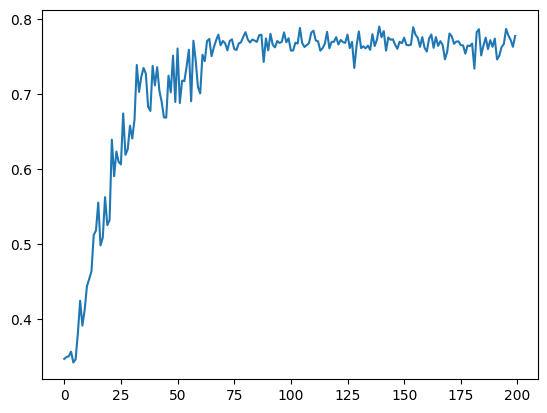

In [6]:
import matplotlib.pyplot as plt
plt.plot(history['acc'])


In [7]:
torch.save(model.state_dict(), 'resnet_simple.pt')